In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek

from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings

In [3]:
df = pd.read_csv("Data/creditcard.csv")


In [4]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [5]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [6]:
X = df.drop('Class', axis=1)
y = df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

d:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


T-SNE took 2.4e+03 s


In [16]:
LR=LogisticRegression(C=0.1,penalty='l1', solver='liblinear',
                    random_state=42)
KNN=KNeighborsClassifier(algorithm='auto',n_neighbors=4)
SVM=SVC(C=0.7,kernel='poly')
DT=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5)

In [17]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced_tsne, y, test_size=0.2, random_state=42)


In [19]:

LR.fit(X_train,y_train)
KNN.fit(X_train,y_train)
SVM.fit(X_train,y_train)
DT.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

AUPRC (Decision Tree): 0.6242391666635415


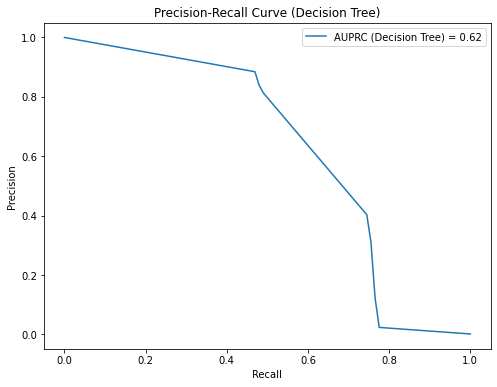

In [20]:

from sklearn.metrics import average_precision_score, precision_recall_curve, auc

# 预测概率
y_proba_tree = DT.predict_proba(X_test)[:, 1]

# 计算AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_proba_tree)
auprc_tree = auc(recall, precision)

# 打印AUPRC
print("AUPRC (Decision Tree):", auprc_tree)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC (Decision Tree) = {auprc_tree:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Decision Tree)')
plt.legend()
plt.show()

AUPRC (kNN): 0.7768677246585517


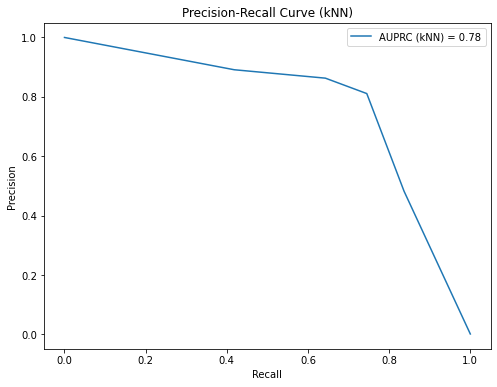

In [23]:
# 预测概率
y_proba_knn = KNN.predict_proba(X_test)[:, 1]

# 计算AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_proba_knn)
auprc_knn = auc(recall, precision)

# 打印AUPRC
print("AUPRC (kNN):", auprc_knn)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC (kNN) = {auprc_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (kNN)')
plt.legend()
plt.show()

AUPRC (Logistic Regression): 0.03484368072018388


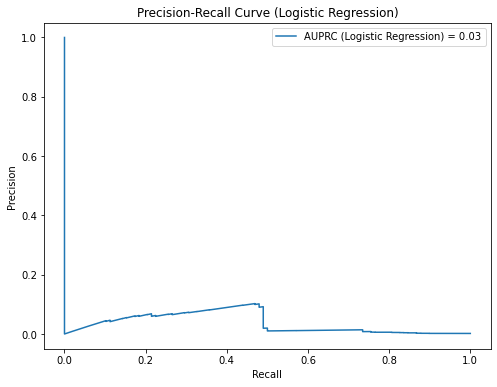

In [24]:
y_proba_logreg = LR.predict_proba(X_test)[:, 1]

# 计算AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_proba_logreg)
auprc_logreg = auc(recall, precision)

# 打印AUPRC
print("AUPRC (Logistic Regression):", auprc_logreg)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC (Logistic Regression) = {auprc_logreg:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Logistic Regression)')
plt.legend()
plt.show()

AUPRC(SVM): 0.0010256885436679614


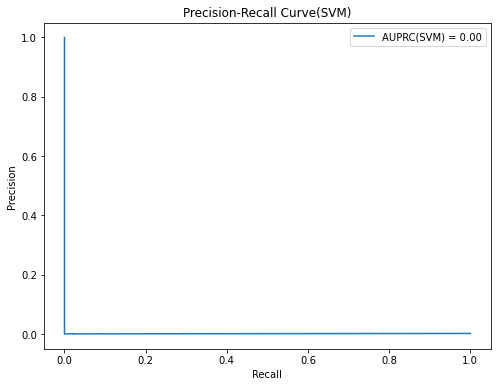

In [25]:
# 预测概率
y_proba_svm = SVM.decision_function(X_test)

# 计算AUPRC
precision, recall, _ = precision_recall_curve(y_test, y_proba_svm)
auprc = auc(recall, precision)

# 打印AUPRC
print("AUPRC(SVM):", auprc)

# 绘制PR曲线
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUPRC(SVM) = {auprc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve(SVM)')
plt.legend()
plt.show()

In [26]:

# 1. 随机过采样
X_train_over, y_train_over = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)

# 2. SMOTE过采样
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

# 3. 随机欠采样
X_train_under, y_train_under = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

# 4. TomekLinks欠采样
X_train_tomek, y_train_tomek = TomekLinks().fit_resample(X_train, y_train)

# 5. ClusterCentroids欠采样
X_train_cluster, y_train_cluster = ClusterCentroids(random_state=42).fit_resample(X_train, y_train)

# 6. SMOTE+TomekLinks混合采样
X_train_smote_tomek, y_train_smote_tomek = SMOTETomek(random_state=42).fit_resample(X_train, y_train)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 定义逻辑回归分类器
LR1 = LogisticRegression(C=0.1,penalty='l1', solver='liblinear',
                    random_state=42)

# 定义函数以训练模型和评估性能
def train_and_evaluate(X_train, y_train, X_test, y_test, sampler_name,classifier=LogisticRegression(C=0.1,penalty='l1', solver='liblinear',
                    random_state=42),cla_name="Logistic Regression"):
    print(f"Training {cla_name} with {sampler_name} sampling:")
    
    # 训练模型
    classifier.fit(X_train, y_train)
    
    y_proba_logreg = classifier.predict_proba(X_test)[:, 1]

    # 计算AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_proba_logreg)
    auprc_logreg = auc(recall, precision)

    # 打印AUPRC
    print(f"AUPRC ({cla_name}):", auprc_logreg)

    # 绘制PR曲线
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUPRC ({cla_name} with {sampler_name}) = {auprc_logreg:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({cla_name})')
    plt.legend()
    plt.show()


Training Logistic Regression with Random Oversampling sampling:
AUPRC (Logistic Regression): 0.02316905746450164


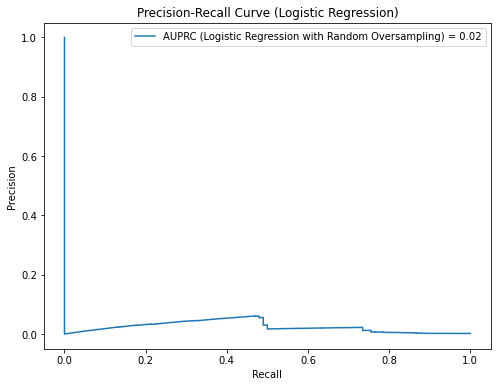

In [29]:

# 对每种采样方法训练和评估逻辑回归分类器
train_and_evaluate(X_train_over, y_train_over, X_test, y_test, "Random Oversampling")


Training Logistic Regression with SMOTE sampling:
AUPRC (Logistic Regression): 0.022844523889357086


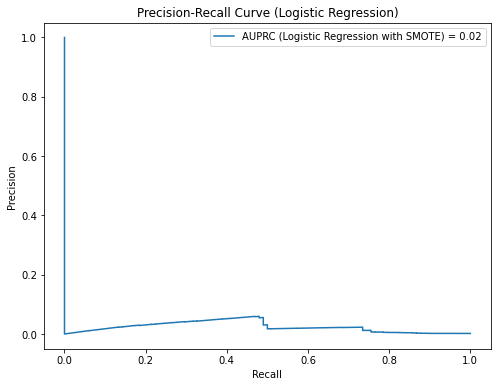

In [30]:

train_and_evaluate(X_train_smote, y_train_smote, X_test, y_test, "SMOTE")


Training Logistic Regression with Random Undersampling sampling:
AUPRC (Logistic Regression): 0.020947645788973863


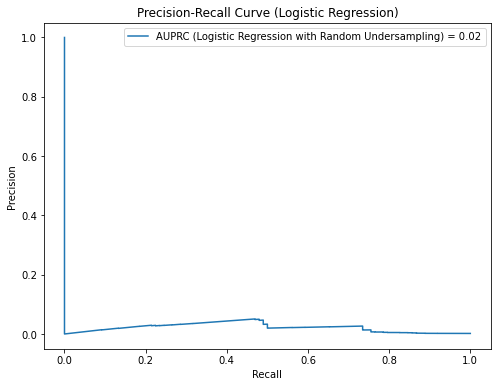

In [31]:

train_and_evaluate(X_train_under, y_train_under, X_test, y_test, "Random Undersampling")


Training Logistic Regression with Tomek Links Undersampling sampling:
AUPRC (Logistic Regression): 0.03484038491026775


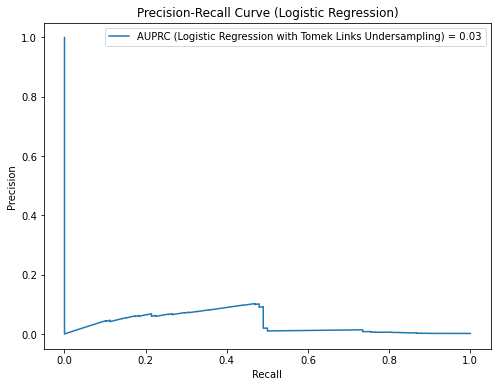

In [32]:

train_and_evaluate(X_train_tomek, y_train_tomek, X_test, y_test, "Tomek Links Undersampling")


Training Logistic Regression with Cluster Centroids Undersampling sampling:
AUPRC (Logistic Regression): 0.0225327591368628


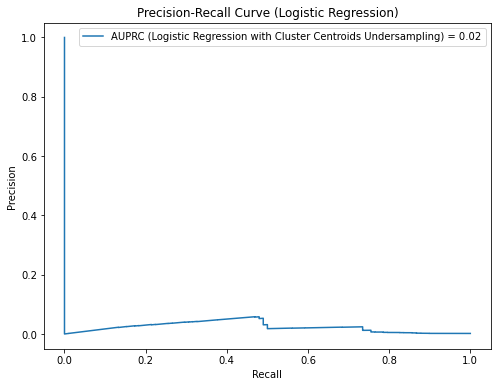

In [33]:
train_and_evaluate(X_train_cluster, y_train_cluster, X_test, y_test, "Cluster Centroids Undersampling")


Training Logistic Regression with SMOTE + Tomek Links sampling:
AUPRC (Logistic Regression): 0.022795151258348505


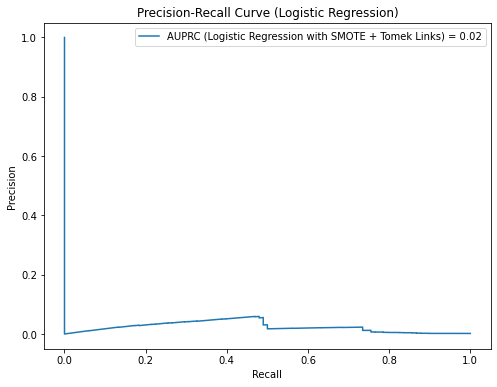

In [34]:

train_and_evaluate(X_train_smote_tomek, y_train_smote_tomek, X_test, y_test, "SMOTE + Tomek Links")


Training KNN with Random Oversampling sampling:
AUPRC (KNN): 0.7401598931465352


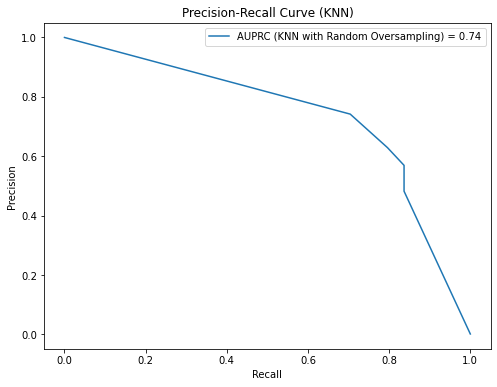

Training KNN with SMOTE sampling:
AUPRC (KNN): 0.503834279048247


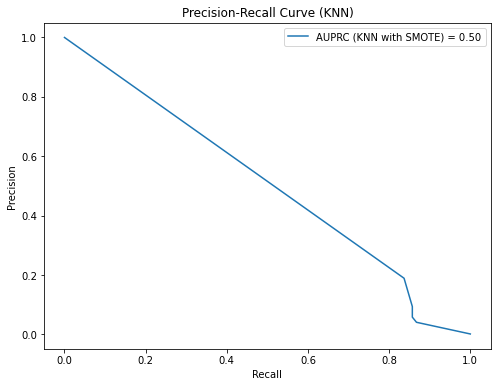

Training KNN with Random Undersampling sampling:
AUPRC (KNN): 0.4183810589917604


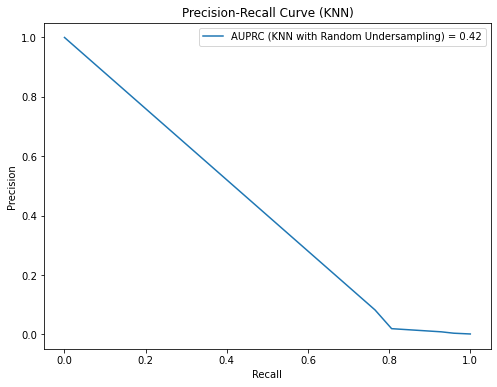

Training KNN with Tomek Links Undersampling sampling:
AUPRC (KNN): 0.7847442092215375


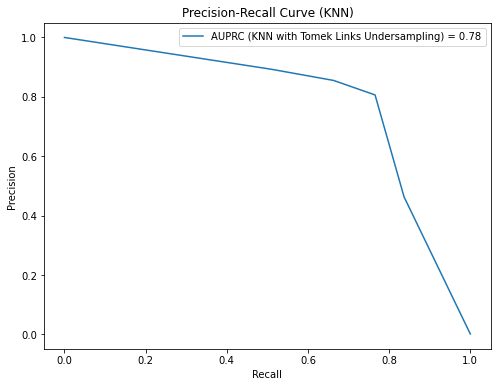

Training KNN with Cluster Centroids Undersampling sampling:
AUPRC (KNN): 0.5032558803118359


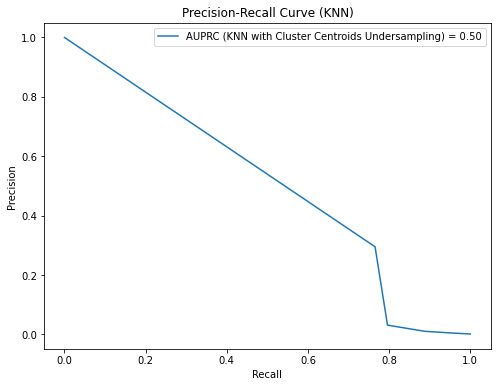

Training KNN with SMOTE + Tomek Links sampling:
AUPRC (KNN): 0.4961767394166716


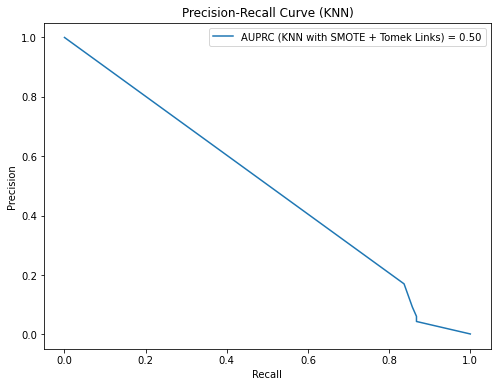

In [38]:
# 对每种采样方法训练和评估逻辑回归分类器
train_and_evaluate(X_train_over, y_train_over, X_test, y_test, "Random Oversampling",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")
train_and_evaluate(X_train_smote, y_train_smote, X_test, y_test, "SMOTE",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")
train_and_evaluate(X_train_under, y_train_under, X_test, y_test, "Random Undersampling",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")
train_and_evaluate(X_train_tomek, y_train_tomek, X_test, y_test, "Tomek Links Undersampling",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")
train_and_evaluate(X_train_cluster, y_train_cluster, X_test, y_test, "Cluster Centroids Undersampling",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")
train_and_evaluate(X_train_smote_tomek, y_train_smote_tomek, X_test, y_test, "SMOTE + Tomek Links",classifier=KNeighborsClassifier(algorithm='auto',n_neighbors=4),cla_name="KNN")

Training Decision Tree with Random Oversampling sampling:
AUPRC (Decision Tree): 0.5112140630528192


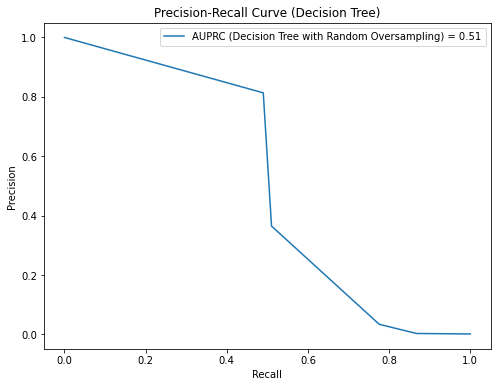

Training Decision Tree with SMOTE sampling:
AUPRC (Decision Tree): 0.5112182564771995


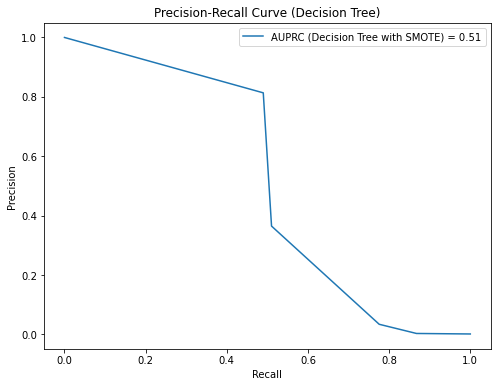

Training Decision Tree with Random Undersampling sampling:
AUPRC (Decision Tree): 0.29449706191870634


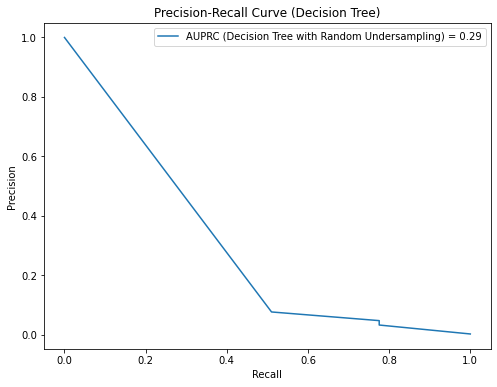

Training Decision Tree with Tomek Links Undersampling sampling:
AUPRC (Decision Tree): 0.6242391666635415


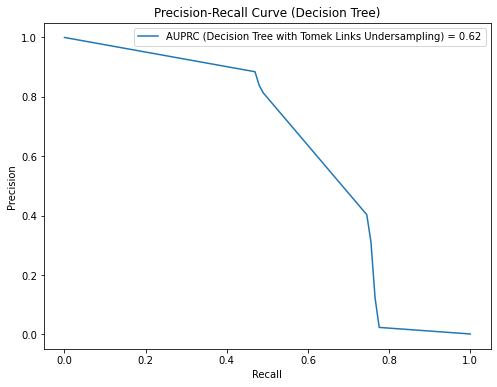

Training Decision Tree with Cluster Centroids Undersampling sampling:
AUPRC (Decision Tree): 0.32200991856935157


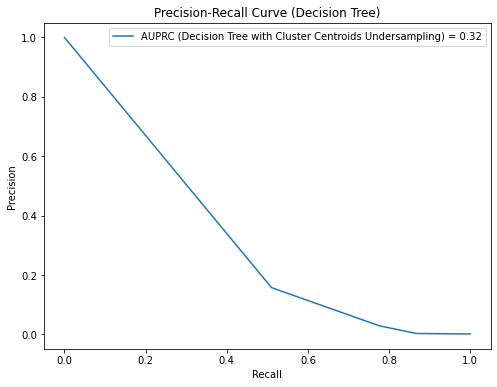

Training Decision Tree with SMOTE + Tomek Links sampling:
AUPRC (Decision Tree): 0.5112182564771995


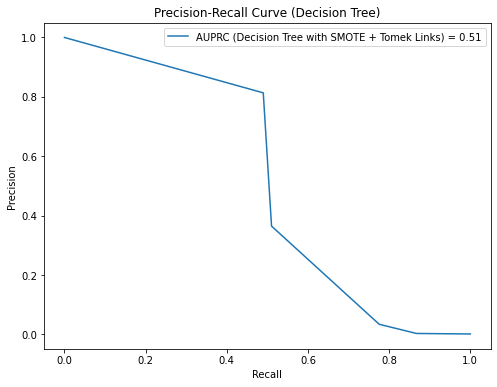

In [39]:
# 对每种采样方法训练和评估逻辑回归分类器
train_and_evaluate(X_train_over, y_train_over, X_test, y_test, "Random Oversampling",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")
train_and_evaluate(X_train_smote, y_train_smote, X_test, y_test, "SMOTE",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")
train_and_evaluate(X_train_under, y_train_under, X_test, y_test, "Random Undersampling",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")
train_and_evaluate(X_train_tomek, y_train_tomek, X_test, y_test, "Tomek Links Undersampling",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")
train_and_evaluate(X_train_cluster, y_train_cluster, X_test, y_test, "Cluster Centroids Undersampling",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")
train_and_evaluate(X_train_smote_tomek, y_train_smote_tomek, X_test, y_test, "SMOTE + Tomek Links",classifier=DecisionTreeClassifier(criterion='gini', max_depth=3,                      
                        min_samples_leaf=5),cla_name="Decision Tree")